In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

### Modell:
$Ax=y$

In [3]:
A = np.random.random(size = (100, 100))
x = np.random.random(size = (100, ))

In [4]:
y = np.dot(A, x)

$A$ ist invertierbar:

In [5]:
np.linalg.inv(A)

array([[ 0.58611217,  0.22754722,  0.22079958, ..., -0.35934623,
         0.66178901,  0.19085717],
       [-0.86053578,  0.35823913, -0.05086583, ..., -0.28753986,
         0.01246512, -1.48921599],
       [ 0.26764428, -0.13717687, -0.92694754, ...,  0.09591585,
        -1.22390556,  2.1684163 ],
       ...,
       [ 0.66359634, -0.39434052,  0.53305901, ...,  0.12365094,
         0.66198343,  0.04954313],
       [-0.06110287,  0.01871632, -0.28590078, ...,  0.03731371,
        -0.48258655,  0.91014539],
       [-1.43651032,  0.47662975, -0.21419412, ..., -0.01676364,
         0.36827009, -2.7539353 ]])

Verlustfunktion: quadratischer Fehler $\Vert y - \hat{y}\Vert^2$

In [6]:
def squared_error(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-2(y_i-\hat{y}_i)$

In [7]:
def grad_loss(y_true, y_pred):
    return (-2) * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [8]:
squared_error(y, np.mean(y))

222.12952243689784

### EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [9]:
iterations = 100
particles = 100
randomization = False

In [10]:
h_0 = 2
epsilon = 0.5

In [11]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [12]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [13]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [14]:
loss_evolution = []
loss_evolution.append(squared_error(y, np.dot(A, param_mean)))

In [15]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

### EnKF

In [16]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(squared_error(y, np.dot(A, param_mean)))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)])))

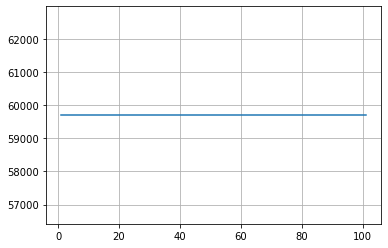

In [17]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.show()

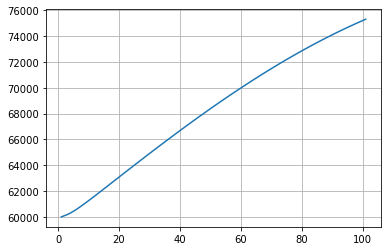

In [18]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.show()

### EnKF wie für inverse Probleme

In [106]:
batch = True
if batch:
    epochs = 10
    batch_size = 10         
else:
    epochs = 100
    batch_size = y.shape[0]

In [107]:
n = y.shape[0]
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [108]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

In [109]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])

In [110]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

In [111]:
loss_evolution = []
loss_evolution.append(squared_error(y, np.dot(A, param_mean)))

In [112]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

In [113]:
for epoch in range(epochs):

    A_batches = [A[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    y_batches = [y[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]

    for b in range(num_batches):

        # update the predictions and the loss for the new parameters
        for i in range(particles):
            y_pred_dict["particle_{}".format(i+1)] = np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])
            loss_dict["particle_{}".format(i+1)] = squared_error(y_batches[b], y_pred_dict["particle_{}".format(i+1)])

        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

        # compute the matrices C
        param_diff_dict = {}
        pred_diff_param_dict = {}
        pred_diff_w_dict = {}
        c_param_w_dict = {}
        c_w_w_dict = {}

        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - param_mean
            pred_diff_param_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = np.transpose(np.tile(param_diff_dict["particle_{}".format(str(i+1))], (pred_diff_param_dict["particle_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_param_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_param_dict["particle_{}".format(str(i+1))], (param_diff_dict["particle_{}".format(str(i+1))].shape[0], 1))
            pred_diff_w_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_w_dict["particle_{}".format(str(i+1))], (pred_diff_w_dict["particle_{}".format(str(i+1))].shape[0], 1))
            c_param_w_dict["particle_{}".format(str(i+1))] = param_diff_dict["particle_{}".format(str(i+1))] * pred_diff_param_dict["particle_{}".format(str(i+1))]
            c_w_w_dict["particle_{}".format(str(i+1))] = pred_diff_w_dict["particle_{}".format(str(i+1))] * pred_diff_w_dict["particle_{}".format(str(i+1))]
        c_param_w = np.mean(list(c_param_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)

        # write the updates back into the dictionary
        for i in range(particles):
            param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w)), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])

        # compute loss for the parameter means
        param_mean = np.mean(list(param_dict.values()), axis = 0)
        loss_evolution.append(squared_error(y_batches[b], np.dot(A_batches[b], param_mean)))

        # zum Testen der einzelnen Partikel
        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(squared_error(y_batches[b], np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])))

In [114]:
loss_evolution

[64212.33772197224,
 321.63622985759963,
 254.42884598443578,
 201.01898025474657,
 156.81322235875095,
 125.63598132404908,
 107.14988684553268,
 86.41939739271294,
 99.19293148931092,
 68.6768755054145,
 70.79004207372726,
 96.6428433595954,
 76.89011648052939,
 86.12760527719749,
 73.55758024555618,
 67.613258410136,
 69.61457811455153,
 46.72868010305609,
 58.718629751158595,
 39.532388062453755,
 51.0912159391666,
 72.87161647621062,
 54.22141624605737,
 66.87018930283324,
 57.533789390604085,
 55.58532254009367,
 61.309926043403436,
 36.47920582276181,
 46.16512086702523,
 30.44928250130018,
 45.03401978884525,
 62.02114186330313,
 44.946228655982644,
 58.20015618038129,
 50.51957430297202,
 50.466316404108206,
 57.5522604281378,
 31.845011127489464,
 39.974461087880826,
 26.086887220054866,
 42.19730031111059,
 55.459363485747794,
 39.96470848749131,
 53.17746332592495,
 46.64023953497153,
 47.673877916479455,
 55.32722990063543,
 29.23480324465848,
 36.279239869902646,
 23.5294

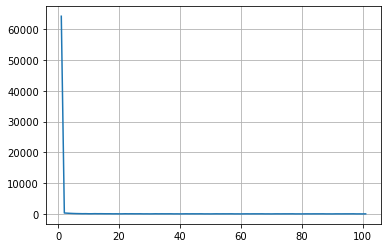

In [115]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.show()

Oszillationen kommen von den Batches. Für jede Batch ist es aber wieder monoton fallend.

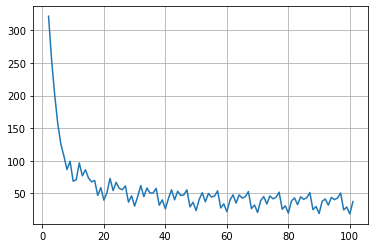

In [119]:
plt.plot(np.arange(len(loss_evolution))[1:]+1, loss_evolution[1:])
plt.grid()
plt.show()

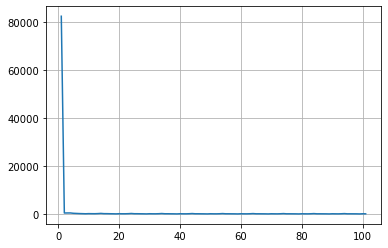

In [116]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.show()

In [117]:
np.dot(A, param_mean)

array([21.61813117, 22.83580607, 27.00802802, 25.32922913, 23.59893435,
       26.76731174, 18.96087729, 23.46166472, 20.35649951, 22.99963967,
       25.50045148, 29.06222676, 24.42801242, 24.86699429, 24.34454738,
       21.66143362, 25.07727777, 25.20886549, 27.99626748, 22.41683762,
       22.59546615, 23.41408594, 22.83698875, 24.63733444, 23.3671652 ,
       22.23796411, 24.7804153 , 25.67805055, 26.38985836, 27.82700646,
       22.81488239, 23.30288078, 22.77492528, 23.08970501, 24.22665503,
       26.94112037, 24.36139371, 26.68487321, 24.74667577, 19.5038816 ,
       27.43154449, 24.09522541, 24.57450583, 22.86052085, 25.65025808,
       25.20641497, 25.52921314, 19.94264673, 19.61835943, 28.54893648,
       24.40749238, 21.14828471, 25.70374383, 24.61202698, 23.33139215,
       24.89342963, 25.60294442, 29.09058518, 24.57565163, 22.60565384,
       26.84430461, 24.60078162, 24.54622935, 25.74990856, 23.51687126,
       22.42211271, 26.50653222, 25.28123349, 23.040166  , 21.86

In [118]:
y

array([24.93864062, 24.09099148, 26.25305628, 24.05640439, 24.64454397,
       28.16979309, 21.67023114, 26.97393195, 22.24643928, 23.35476629,
       27.45352245, 28.53033815, 24.320793  , 27.63236822, 26.14936327,
       24.90531817, 26.07236955, 24.33898551, 26.91819902, 24.20534451,
       25.79499432, 25.88499083, 24.38543291, 25.83176522, 26.83586517,
       24.80273558, 22.71865125, 25.45981492, 26.10706738, 26.89293316,
       24.56265758, 24.8690558 , 23.51943907, 26.20412968, 27.53174095,
       25.37415973, 22.81567239, 25.32572346, 25.50640985, 22.03874206,
       25.24601192, 25.36932264, 24.53813854, 24.3565557 , 25.45253073,
       25.72562487, 26.47877767, 23.9623008 , 23.17563746, 26.54070402,
       23.38731952, 25.96615031, 24.79512153, 25.96092475, 23.95455273,
       24.66617169, 24.75855335, 26.37392893, 24.86833134, 26.45302213,
       26.41893908, 23.37025624, 25.94386236, 25.1289184 , 26.35923403,
       23.85443521, 25.14067224, 26.29386487, 23.66160306, 24.53